# Geospatial Analysis of Hospitals Access in Peru

### Data Sources:
- **Hospitals (MINSA – IPRESS)**: National registry of operational hospitals
- **Population Centers (INEI)**: Population centers dataset
- **Administrative Boundaries**: Districts of Peru shapefile

### Methodology:
- Filter hospitals to only operational facilities with valid coordinates
- Use EPSG:4326 CRS for consistent geographic analysis

## 1. Import Libraries and Load Data

In [48]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [49]:
# Load hospitals data
hospitals_df = pd.read_csv('data/IPRESS.csv', encoding='latin-1')
print(f"Hospitals dataset shape: {hospitals_df.shape}")

# Load districts shapefile
districts_gdf = gpd.read_file('data/DISTRITOS.shp')
print(f"Districts shapefile shape: {districts_gdf.shape}")

# Load population centers shapefile
pop_centers_gdf = gpd.read_file('data/CCPP_IGN100K.shp')
print(f"Population centers shapefile shape: {pop_centers_gdf.shape}")

Hospitals dataset shape: (20819, 33)
Districts shapefile shape: (1873, 11)
Population centers shapefile shape: (136587, 14)
Population centers shapefile shape: (136587, 14)


## 2. Data Exploration and Cleaning

In [50]:
# Filter for operational hospitals ("EN FUNCIONAMIENTO")
operational_hospitals = hospitals_df[hospitals_df['Condición'] == 'EN FUNCIONAMIENTO'].copy()
print(f"Operational hospitals: {len(operational_hospitals)}")

# Filter for hospitals with valid coordinates (NORTE and ESTE columns)
valid_coords = operational_hospitals.dropna(subset=['NORTE', 'ESTE'])
print(f"With valid coordinates: {len(valid_coords)}")

# Convert coordinates to numeric, replacing any non-numeric values with NaN
valid_coords['NORTE'] = pd.to_numeric(valid_coords['NORTE'], errors='coerce')
valid_coords['ESTE'] = pd.to_numeric(valid_coords['ESTE'], errors='coerce')

# Remove rows with zero coordinates (invalid locations)
valid_coords = valid_coords[(valid_coords['NORTE'] != 0) & (valid_coords['ESTE'] != 0)]

print(f"After cleaning coordinates: {len(valid_coords)}")

# Check coordinate format
norte_sample = valid_coords['NORTE'].dropna().iloc[:10]
este_sample = valid_coords['ESTE'].dropna().iloc[:10]
print(f"\nSample NORTE values: {norte_sample.tolist()}")
print(f"Sample ESTE values: {este_sample.tolist()}")

# Check if coordinates are in UTM or lat/lon format
if valid_coords['NORTE'].abs().max() > 90 or valid_coords['ESTE'].abs().max() > 180:
    print("Coordinates appear to be in UTM format")
else:
    print("Coordinates appear to be in lat/lon format")

Operational hospitals: 20800
With valid coordinates: 7942
After cleaning coordinates: 7939

Sample NORTE values: [-78.85838013, -74.25813893, -76.9306076, -74.29653113, -75.88581167, -69.03532667, -70.19933924, -69.62749511, -70.13631597, -76.45851307]
Sample ESTE values: [-6.1335228, -4.58150907, -12.2486993, -8.39836581, -6.43829833, -16.26196833, -14.9041434, -15.29109598, -15.47227834, -10.67929002]
Coordinates appear to be in lat/lon format


In [51]:
# Create geometry from coordinates (NORTE=longitude, ESTE=latitude - they are swapped in the dataset)
geometry = [Point(xy) for xy in zip(valid_coords['NORTE'], valid_coords['ESTE'])]

# Create GeoDataFrame
hospitals_gdf = gpd.GeoDataFrame(valid_coords, geometry=geometry, crs='EPSG:4326')

In [52]:
# Ensure districts are in EPSG:4326
if districts_gdf.crs != 'EPSG:4326':
    districts_gdf = districts_gdf.to_crs('EPSG:4326')
    print("\nConverted districts to EPSG:4326")

In [53]:
# Ensure population centers are in EPSG:4326
if pop_centers_gdf.crs != 'EPSG:4326':
    pop_centers_gdf = pop_centers_gdf.to_crs('EPSG:4326')
    print("\nConverted population centers to EPSG:4326")

## 3. Task 1: Static Maps - Hospital Count by District

In [54]:
# Preparar códigos: UBIGEO completar con 0s a la izquierda para 6 dígitos
hospitals_gdf['UBIGEO_clean'] = hospitals_gdf['UBIGEO'].astype(str).str.zfill(6)
districts_gdf['IDDIST_clean'] = districts_gdf['IDDIST'].astype(str)

print(f"Total hospitales a asignar: {len(hospitals_gdf)}")

# Merge directo por códigos
hospitals_with_districts = hospitals_gdf.merge(
    districts_gdf[['IDDIST_clean']], 
    left_on='UBIGEO_clean', 
    right_on='IDDIST_clean', 
    how='left'
)

assigned_count = hospitals_with_districts['IDDIST_clean'].notna().sum()
print(f"Hospitales asignados: {assigned_count} de {len(hospitals_gdf)}")

# Contar hospitales por distrito
hospital_counts = (hospitals_with_districts.dropna(subset=['IDDIST_clean'])
                  .groupby('IDDIST_clean').size()
                  .reset_index(name='hospital_count'))

# Merge final con distritos
districts_with_counts = districts_gdf.merge(
    hospital_counts, 
    on='IDDIST_clean', 
    how='left'
).fillna({'hospital_count': 0})

print(f"Distritos con cero hospitales: {(districts_with_counts['hospital_count'] == 0).sum()} de {len(districts_with_counts)}")

Total hospitales a asignar: 7939
Hospitales asignados: 7891 de 7939
Distritos con cero hospitales: 62 de 1873


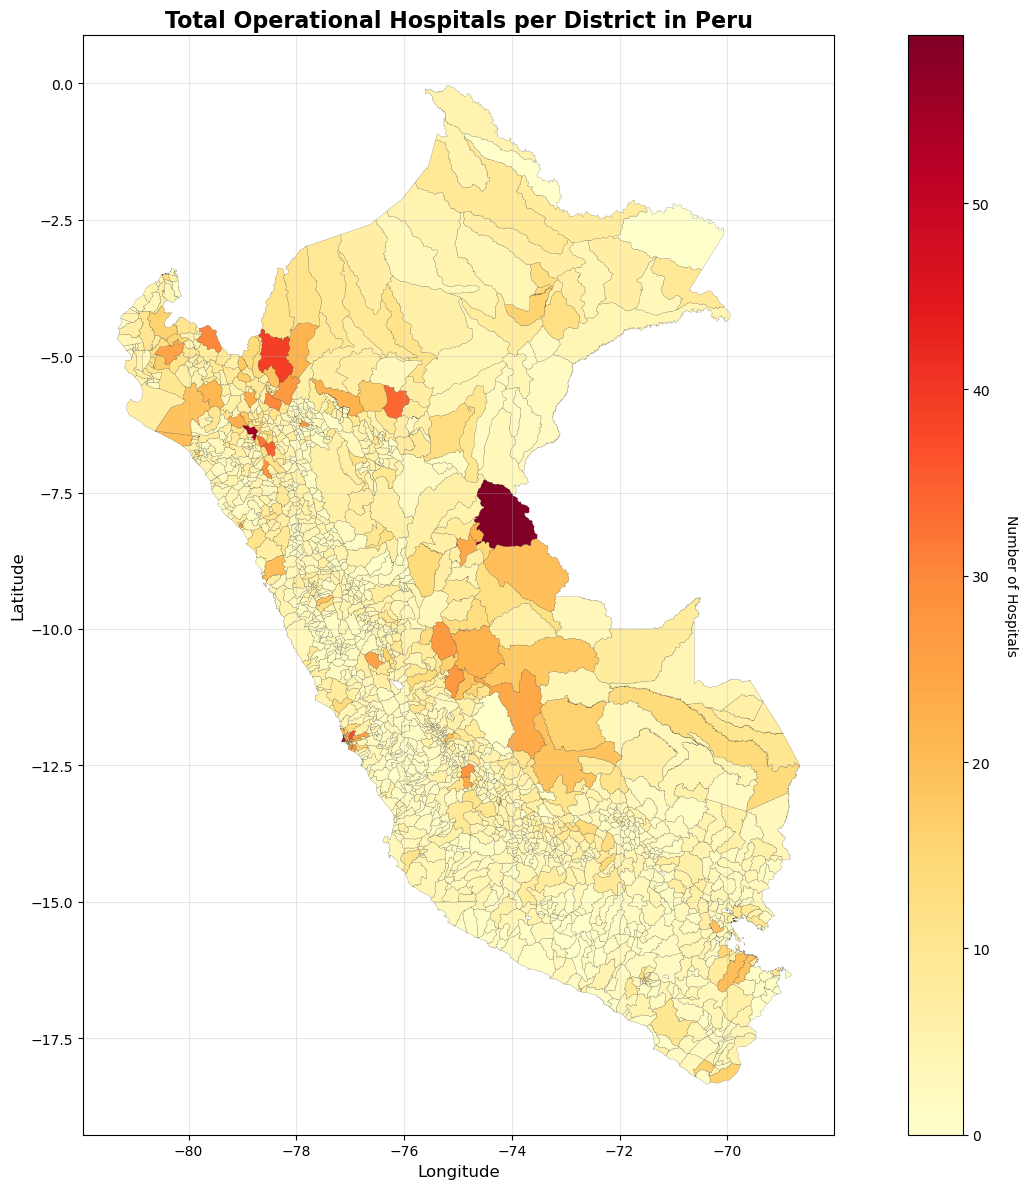

In [55]:
# Map 1: Total operational hospitals per district
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

districts_with_counts.plot(column='hospital_count', 
                          cmap='YlOrRd', 
                          legend=True,
                          ax=ax,
                          edgecolor='black',
                          linewidth=0.1)

ax.set_title('Total Operational Hospitals per District in Peru', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3)

# Add colorbar label
cbar = ax.get_figure().get_axes()[-1]
cbar.set_ylabel('Number of Hospitals', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

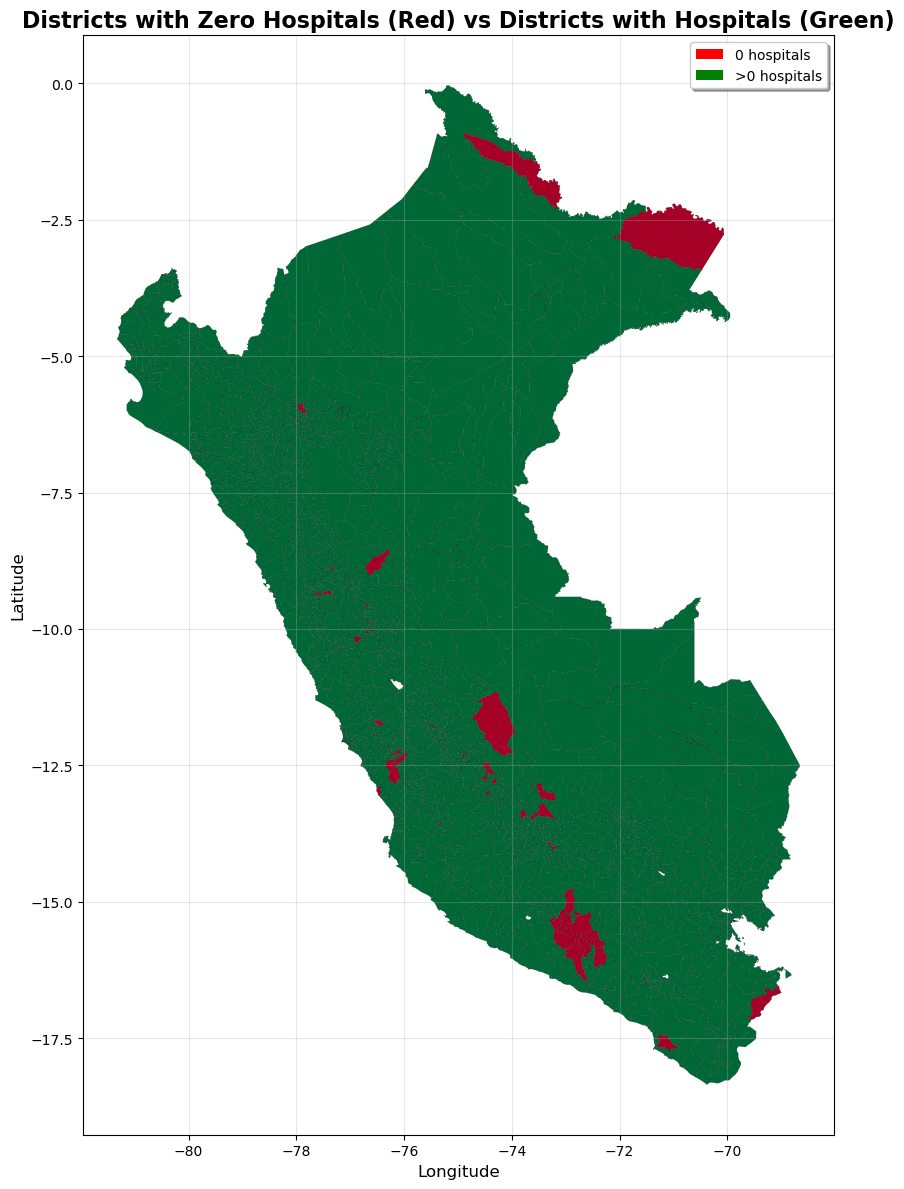


Districts with zero hospitals: 62 out of 1873 (3.3%)


In [56]:
# Map 2: Districts with zero hospitals
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Create a binary color map for zero vs non-zero hospitals
districts_with_counts['has_hospital'] = districts_with_counts['hospital_count'] > 0

districts_with_counts.plot(column='has_hospital', 
                          cmap='RdYlGn', 
                          legend=False,  # Disable automatic legend
                          ax=ax,
                          edgecolor='black',
                          linewidth=0.1)

ax.set_title('Districts with Zero Hospitals (Red) vs Districts with Hospitals (Green)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3)

# Add custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='0 hospitals'),
    Patch(facecolor='green', label='>0 hospitals')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

# Statistics
zero_hospitals = (districts_with_counts['hospital_count'] == 0).sum()
total_districts = len(districts_with_counts)
print(f"\nDistricts with zero hospitals: {zero_hospitals} out of {total_districts} ({zero_hospitals/total_districts*100:.1f}%)")

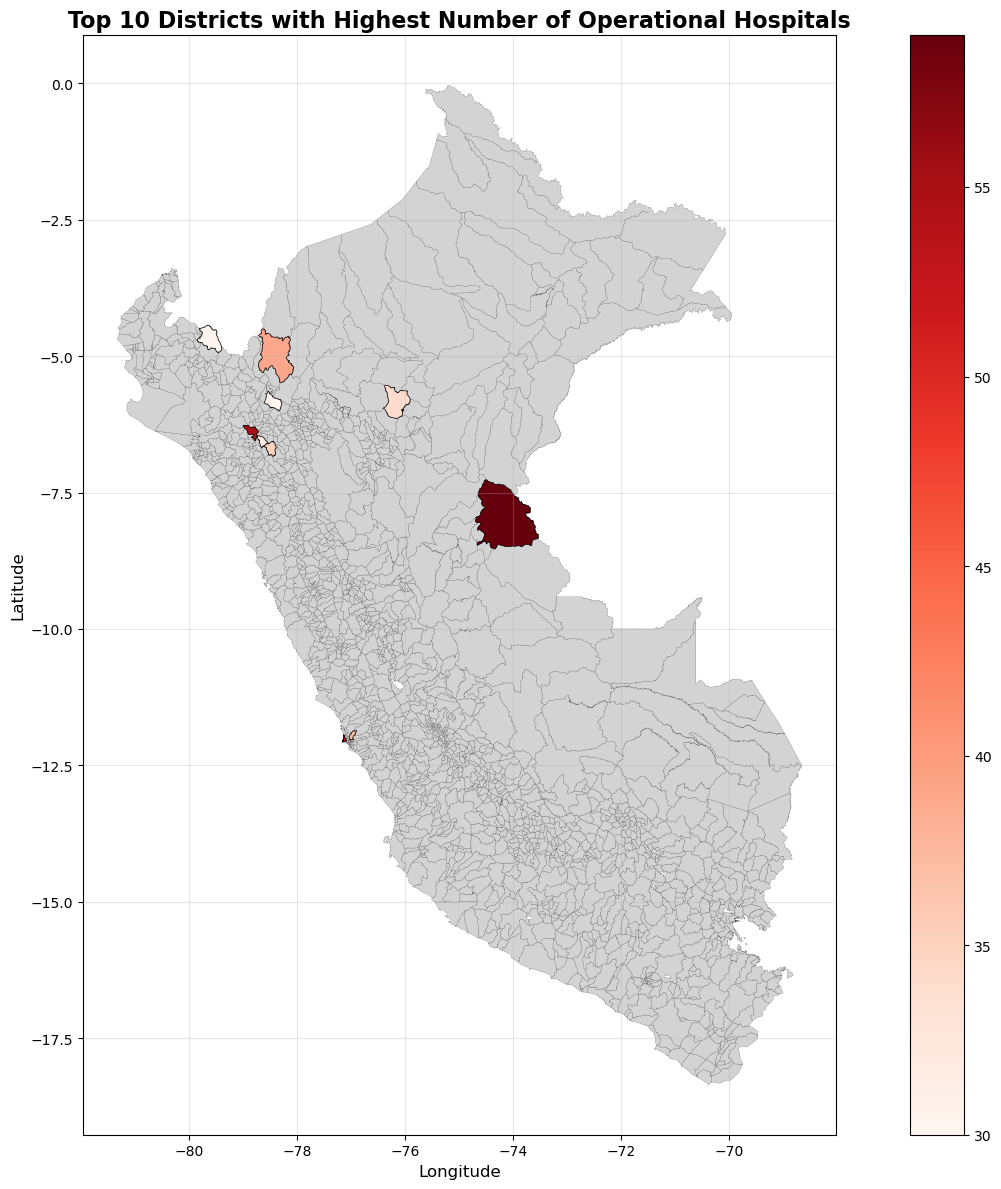


Top 10 Districts by Number of Operational Hospitals
                    DISTRITO  hospital_count
1374                CALLERIA            59.0
314                  CUTERVO            55.0
1295                  CALLAO            51.0
1687                   IMAZA            39.0
1300  SAN JUAN DE LURIGANCHO            37.0
1643              BAMBAMARCA            35.0
1588              YURIMAGUAS            34.0
1579                   CHOTA            32.0
1586            BAGUA GRANDE            30.0
1730                 AYABACA            30.0


In [57]:
# Map 3: Top 10 districts with highest number of hospitals
top_10_districts = districts_with_counts.nlargest(10, 'hospital_count')

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot all districts in light gray
districts_with_counts.plot(color='lightgray', 
                          ax=ax,
                          edgecolor='black',
                          linewidth=0.1)

# Highlight top 10 districts
top_10_districts.plot(column='hospital_count', 
                     cmap='Reds', 
                     legend=True,
                     ax=ax,
                     edgecolor='black',
                     linewidth=0.5)

ax.set_title('Top 10 Districts with Highest Number of Operational Hospitals', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show top 10 districts table
print("\nTop 10 Districts by Number of Operational Hospitals")
if 'DISTRITO' in top_10_districts.columns:
    print(top_10_districts[['DISTRITO', 'hospital_count']].sort_values('hospital_count', ascending=False))
else:
    print(top_10_districts[['hospital_count']].sort_values('hospital_count', ascending=False))

## 4. Task 2: Department-level Analysis

In [58]:
# Aggregate at department level - ALL OPERATIONAL HOSPITALS
print("=== DEPARTMENT-LEVEL ANALYSIS (ALL OPERATIONAL HOSPITALS) ===")

# Count hospitals by department using all valid hospitals
dept_counts = valid_coords['Departamento'].value_counts().reset_index()
dept_counts.columns = ['Departamento', 'hospital_count']
dept_counts = dept_counts.sort_values('hospital_count', ascending=False)

print(f"Total departments: {len(dept_counts)}")
print(f"Department with most hospitals: {dept_counts.iloc[0]['Departamento']} ({dept_counts.iloc[0]['hospital_count']} hospitals)")
print(f"Department with fewest hospitals: {dept_counts.iloc[-1]['Departamento']} ({dept_counts.iloc[-1]['hospital_count']} hospitals)")
print(f"Total operational hospitals: {dept_counts['hospital_count'].sum()}")

=== DEPARTMENT-LEVEL ANALYSIS (ALL OPERATIONAL HOSPITALS) ===
Total departments: 25
Department with most hospitals: CAJAMARCA (845 hospitals)
Department with fewest hospitals: TUMBES (54 hospitals)
Total operational hospitals: 7939


In [59]:
# Summary table
print("\nDepartment-level Hospital Counts (ALL Operational Hospitals):")
print(dept_counts.to_string(index=False))

# Additional statistics
print(f"\nSummary Statistics:")
print(f"Mean hospitals per department: {dept_counts['hospital_count'].mean():.2f}")
print(f"Median hospitals per department: {dept_counts['hospital_count'].median():.2f}")
print(f"Standard deviation: {dept_counts['hospital_count'].std():.2f}")
print(f"Departments with >100 hospitals: {(dept_counts['hospital_count'] > 100).sum()}")
print(f"Departments with <10 hospitals: {(dept_counts['hospital_count'] < 10).sum()}")


Department-level Hospital Counts (ALL Operational Hospitals):
 Departamento  hospital_count
    CAJAMARCA             845
         LIMA             774
        JUNIN             493
        PIURA             442
     AMAZONAS             417
       ANCASH             416
         PUNO             405
     AYACUCHO             387
   SAN MARTIN             379
     APURIMAC             374
       LORETO             351
        CUSCO             339
  LA LIBERTAD             336
 HUANCAVELICA             325
      HUANUCO             261
        PASCO             258
      UCAYALI             234
     AREQUIPA             224
   LAMBAYEQUE             181
          ICA             146
       CALLAO              97
        TACNA              79
MADRE DE DIOS              66
     MOQUEGUA              56
       TUMBES              54

Summary Statistics:
Mean hospitals per department: 317.56
Median hospitals per department: 336.00
Standard deviation: 199.07
Departments with >100 hospitals

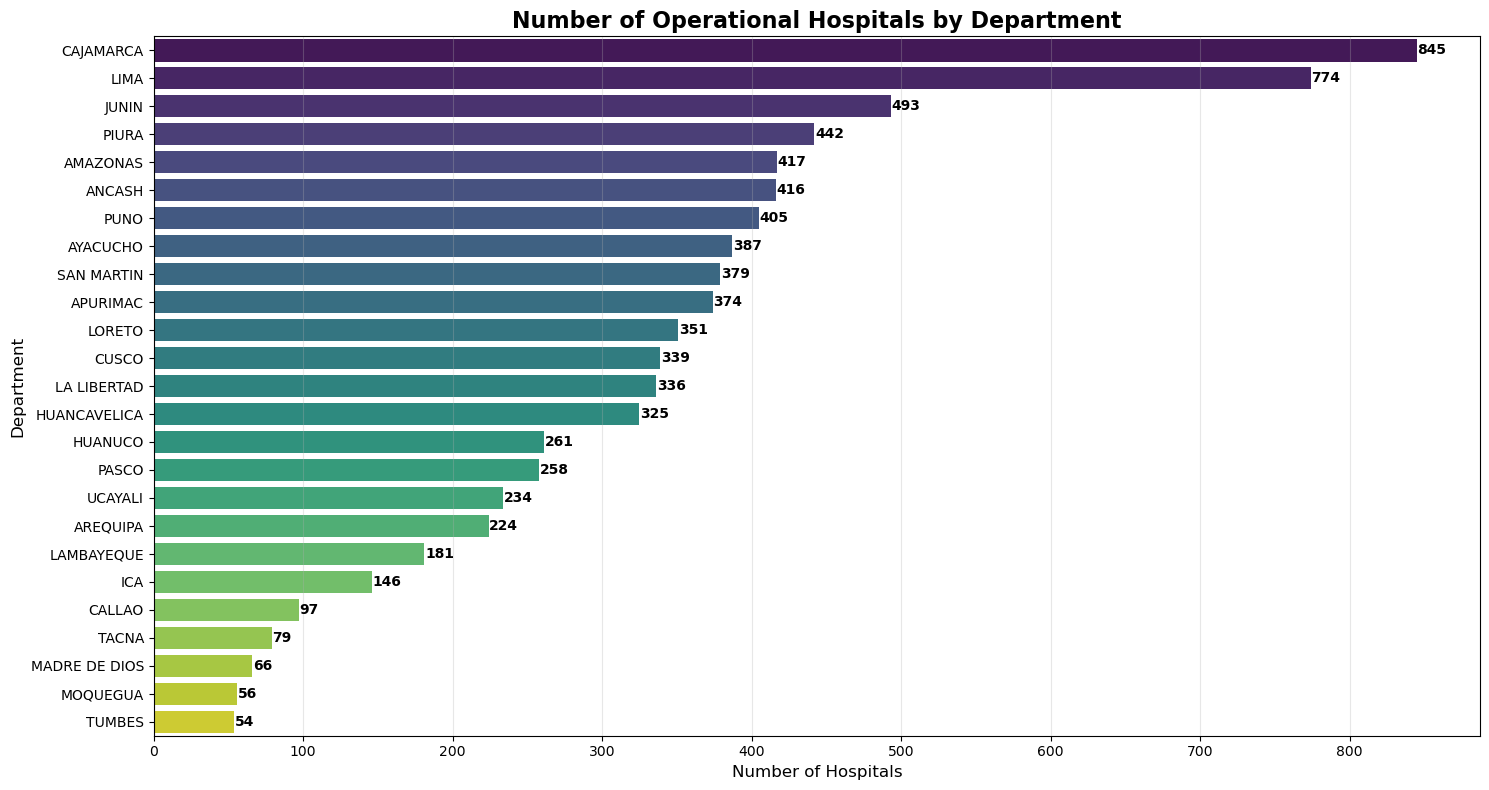

In [60]:
# Bar chart
plt.figure(figsize=(15, 8))
sns.barplot(data=dept_counts, x='hospital_count', y='Departamento', palette='viridis')
plt.title('Number of Operational Hospitals by Department', fontsize=16, fontweight='bold')
plt.xlabel('Number of Hospitals', fontsize=12)
plt.ylabel('Department', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(dept_counts['hospital_count']):
    plt.text(v + 0.5, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

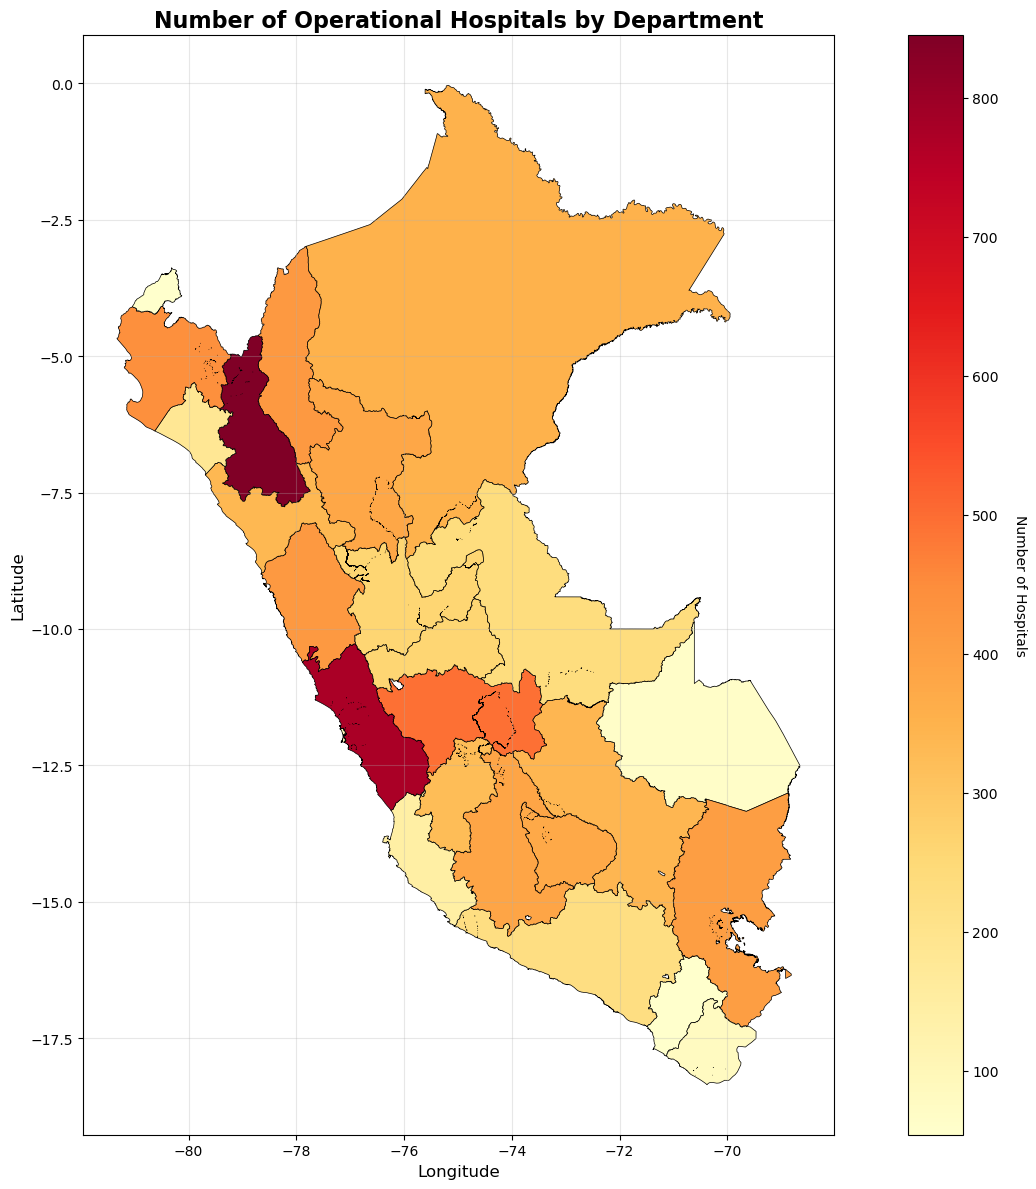

In [61]:
# Department-level choropleth map
departments_gdf = districts_gdf.dissolve(by='DEPARTAMEN').reset_index()

# Merge with hospital counts
departments_with_counts = departments_gdf.merge(dept_counts, 
                                               left_on='DEPARTAMEN', 
                                               right_on='Departamento', 
                                               how='left')
departments_with_counts['hospital_count'] = departments_with_counts['hospital_count'].fillna(0)

# Create choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

departments_with_counts.plot(column='hospital_count', 
                           cmap='YlOrRd', 
                           legend=True,
                           ax=ax,
                           edgecolor='black',
                           linewidth=0.5)

ax.set_title('Number of Operational Hospitals by Department', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3)

# Add colorbar label
cbar = ax.get_figure().get_axes()[-1]
cbar.set_ylabel('Number of Hospitals', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

## 5. Task 3: Proximity Analysis - Lima and Loreto

In [62]:
# Step 1: Filter hospitals for target regions
lima_hospitals = hospitals_gdf[hospitals_gdf['Departamento'] == 'LIMA'].copy()
loreto_hospitals = hospitals_gdf[hospitals_gdf['Departamento'] == 'LORETO'].copy()

print(f"✓ Lima hospitals: {len(lima_hospitals)}")
print(f"✓ Loreto hospitals: {len(loreto_hospitals)}")

# Step 2: Check population centers columns
print(f"✓ Population centers columns: {list(pop_centers_gdf.columns)}")

# Step 3: Use spatial join approach with department boundaries
# Get Lima and Loreto department boundaries
lima_dept = departments_gdf[departments_gdf['DEPARTAMEN'] == 'LIMA'].copy()
loreto_dept = departments_gdf[departments_gdf['DEPARTAMEN'] == 'LORETO'].copy()

print(f"✓ Lima department boundary: {len(lima_dept)} polygon(s)")
print(f"✓ Loreto department boundary: {len(loreto_dept)} polygon(s)")

# Spatial join to get population centers within each department
if len(lima_dept) > 0:
    lima_pop = gpd.sjoin(pop_centers_gdf, lima_dept, how='inner', predicate='within')
    print(f"✓ Lima population centers (spatial join): {len(lima_pop)}")
else:
    lima_pop = pd.DataFrame()

if len(loreto_dept) > 0:
    loreto_pop = gpd.sjoin(pop_centers_gdf, loreto_dept, how='inner', predicate='within')
    print(f"✓ Loreto population centers (spatial join): {len(loreto_pop)}")
else:
    loreto_pop = pd.DataFrame()


✓ Lima hospitals: 774
✓ Loreto hospitals: 351
✓ Population centers columns: ['OBJECTID', 'NOM_POBLAD', 'FUENTE', 'CÓDIGO', 'CAT_POBLAD', 'DIST', 'PROV', 'DEP', 'CÓD_INT', 'CATEGORIA', 'X', 'Y', 'N_BUSQDA', 'geometry']
✓ Lima department boundary: 1 polygon(s)
✓ Loreto department boundary: 1 polygon(s)
✓ Lima population centers (spatial join): 7610
✓ Loreto population centers (spatial join): 3426


In [63]:
# Step 4: Define improved buffer calculation function
def calculate_hospitals_in_buffer(centroid_point, hospitals_gdf, buffer_km=10):
    """
    Calculate hospitals within buffer around a population center centroid.
    
    Parameters:
    - centroid_point: Point geometry (EPSG:4326)
    - hospitals_gdf: GeoDataFrame with hospitals (EPSG:4326) 
    - buffer_km: Buffer radius in kilometers
    
    Returns:
    - int: Count of hospitals within buffer
    """
    if hospitals_gdf is None or len(hospitals_gdf) == 0:
        return 0
    
    # Project to UTM Zone 18S (EPSG:32718) for accurate metric calculations
    # This covers Peru's territory more accurately than degree approximations
    centroid_utm = gpd.GeoSeries([centroid_point], crs='EPSG:4326').to_crs('EPSG:32718').iloc[0]
    hospitals_utm = hospitals_gdf.to_crs('EPSG:32718')
    
    # Create precise 10km buffer in meters
    buffer_geom = centroid_utm.buffer(buffer_km * 1000)  # Convert km to meters
    
    # Count hospitals within buffer
    hospitals_in_buffer = hospitals_utm[hospitals_utm.geometry.within(buffer_geom)]
    return len(hospitals_in_buffer)

print("✓ Buffer calculation function defined (using EPSG:32718 for metric accuracy)")

# Step 5: Lima Analysis
if len(lima_pop) > 0 and len(lima_hospitals) > 0:
    print("\n--- LIMA ANALYSIS ---")
    
    # Calculate hospitals within 10km for each population center
    lima_pop['hospitals_10km'] = lima_pop.geometry.apply(
        lambda geom: calculate_hospitals_in_buffer(geom, lima_hospitals, 10)
    )
    
    # Remove any centers with no data
    lima_pop = lima_pop.dropna(subset=['hospitals_10km'])
    
    if len(lima_pop) > 0:
        # Find isolation and concentration extremes
        lima_isolation_idx = lima_pop['hospitals_10km'].idxmin()
        lima_concentration_idx = lima_pop['hospitals_10km'].idxmax()
        
        lima_isolation = lima_pop.loc[lima_isolation_idx]
        lima_concentration = lima_pop.loc[lima_concentration_idx]
        
        print(f"✓ Most isolated center: {lima_isolation['hospitals_10km']} hospitals within 10km")
        print(f"✓ Most concentrated center: {lima_concentration['hospitals_10km']} hospitals within 10km")
        
        # Summary statistics
        print(f"✓ Average hospitals per center: {lima_pop['hospitals_10km'].mean():.1f}")
        print(f"✓ Centers with 0 hospitals nearby: {(lima_pop['hospitals_10km'] == 0).sum()}")
    else:
        print("❌ No valid Lima population centers after analysis")
        lima_isolation = lima_concentration = None
else:
    print("❌ Insufficient data for Lima analysis")
    lima_isolation = lima_concentration = None

✓ Buffer calculation function defined (using EPSG:32718 for metric accuracy)

--- LIMA ANALYSIS ---
✓ Most isolated center: 0 hospitals within 10km
✓ Most concentrated center: 223 hospitals within 10km
✓ Average hospitals per center: 6.8
✓ Centers with 0 hospitals nearby: 937
✓ Most isolated center: 0 hospitals within 10km
✓ Most concentrated center: 223 hospitals within 10km
✓ Average hospitals per center: 6.8
✓ Centers with 0 hospitals nearby: 937


In [64]:
# Step 6: Loreto Analysis
if len(loreto_pop) > 0 and len(loreto_hospitals) > 0:
    print("\n--- LORETO ANALYSIS ---")
    
    # Calculate hospitals within 10km for each population center
    loreto_pop['hospitals_10km'] = loreto_pop.geometry.apply(
        lambda geom: calculate_hospitals_in_buffer(geom, loreto_hospitals, 10)
    )
    
    # Remove any centers with no data
    loreto_pop = loreto_pop.dropna(subset=['hospitals_10km'])
    
    if len(loreto_pop) > 0:
        # Find isolation and concentration extremes
        loreto_isolation_idx = loreto_pop['hospitals_10km'].idxmin()
        loreto_concentration_idx = loreto_pop['hospitals_10km'].idxmax()
        
        loreto_isolation = loreto_pop.loc[loreto_isolation_idx]
        loreto_concentration = loreto_pop.loc[loreto_concentration_idx]
        
        print(f"✓ Most isolated center: {loreto_isolation['hospitals_10km']} hospitals within 10km")
        print(f"✓ Most concentrated center: {loreto_concentration['hospitals_10km']} hospitals within 10km")
        
        # Summary statistics
        print(f"✓ Average hospitals per center: {loreto_pop['hospitals_10km'].mean():.1f}")
        print(f"✓ Centers with 0 hospitals nearby: {(loreto_pop['hospitals_10km'] == 0).sum()}")
    else:
        print("❌ No valid Loreto population centers after analysis")
        loreto_isolation = loreto_concentration = None
else:
    print("❌ Insufficient data for Loreto analysis")
    loreto_isolation = loreto_concentration = None



--- LORETO ANALYSIS ---
✓ Most isolated center: 0 hospitals within 10km
✓ Most concentrated center: 29 hospitals within 10km
✓ Average hospitals per center: 1.8
✓ Centers with 0 hospitals nearby: 1183
✓ Most isolated center: 0 hospitals within 10km
✓ Most concentrated center: 29 hospitals within 10km
✓ Average hospitals per center: 1.8
✓ Centers with 0 hospitals nearby: 1183


## 6. Interactive Mapping with Folium

In [65]:
# Create national choropleth map
print("Creating national choropleth map...")

# Create Peru center coordinates
peru_center = [-9.19, -75.0152]
national_map = folium.Map(location=peru_center, zoom_start=6)

# Add choropleth layer for districts
if 'hospital_count' in districts_with_counts.columns:
    folium.Choropleth(
        geo_data=districts_with_counts,
        data=districts_with_counts,
        columns=['IDDIST', 'hospital_count'],
        key_on='feature.properties.IDDIST',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Number of Hospitals per District'
    ).add_to(national_map)
    
    # Add major hospitals as markers
    for idx, hospital in hospitals_gdf.head(50).iterrows():  # Show top 50 for performance
        if pd.notna(hospital.geometry.y) and pd.notna(hospital.geometry.x):
            folium.Marker(
                location=[hospital.geometry.y, hospital.geometry.x],
                popup=f"{hospital['Nombre del establecimiento']}<br>Type: {hospital['Tipo']}",
                icon=folium.Icon(color='blue', icon='plus-sign', prefix='fa')
            ).add_to(national_map)
    
    print("National choropleth map created successfully!")
    national_map
else:
    print("Error: 'hospital_count' column not found in districts_with_counts")

Creating national choropleth map...
National choropleth map created successfully!
National choropleth map created successfully!


In [66]:
# Step 8: Lima Proximity Visualization
if 'lima_isolation' in locals() and lima_isolation is not None and 'lima_concentration' in locals() and lima_concentration is not None:
    print("Creating Lima proximity analysis map...")
    
    # Create Lima-centered map
    lima_center = [-12.0464, -77.0428]  # Lima coordinates
    lima_map = folium.Map(
        location=lima_center, 
        zoom_start=10,
        tiles='OpenStreetMap'
    )
    
    # Add isolated population center (red)
    folium.Marker(
        location=[lima_isolation.geometry.y, lima_isolation.geometry.x],
        popup=folium.Popup(
            f"<b>Most Isolated Center</b><br>"
            f"Hospitals within 10km: {lima_isolation['hospitals_10km']}<br>"
            f"Coordinates: ({lima_isolation.geometry.y:.4f}, {lima_isolation.geometry.x:.4f})",
            max_width=300
        ),
        icon=folium.Icon(color='red', icon='exclamation-sign', prefix='fa')
    ).add_to(lima_map)
    
    # Add 10km buffer for isolated center
    folium.Circle(
        location=[lima_isolation.geometry.y, lima_isolation.geometry.x],
        radius=10000,  # 10 km in meters
        color='red',
        fillColor='red',
        fillOpacity=0.1,
        weight=2,
        popup=f"10km buffer - {lima_isolation['hospitals_10km']} hospitals"
    ).add_to(lima_map)
    
    # Add concentrated population center (green)
    folium.Marker(
        location=[lima_concentration.geometry.y, lima_concentration.geometry.x],
        popup=folium.Popup(
            f"<b>Most Concentrated Center</b><br>"
            f"Hospitals within 10km: {lima_concentration['hospitals_10km']}<br>"
            f"Coordinates: ({lima_concentration.geometry.y:.4f}, {lima_concentration.geometry.x:.4f})",
            max_width=300
        ),
        icon=folium.Icon(color='green', icon='plus-sign', prefix='fa')
    ).add_to(lima_map)
    
    # Add 10km buffer for concentrated center
    folium.Circle(
        location=[lima_concentration.geometry.y, lima_concentration.geometry.x],
        radius=10000,  # 10 km in meters
        color='green',
        fillColor='green',
        fillOpacity=0.1,
        weight=2,
        popup=f"10km buffer - {lima_concentration['hospitals_10km']} hospitals"
    ).add_to(lima_map)
    
    # Add all Lima hospitals
    for idx, hospital in lima_hospitals.iterrows():
        if pd.notna(hospital.geometry.y) and pd.notna(hospital.geometry.x):
            folium.CircleMarker(
                location=[hospital.geometry.y, hospital.geometry.x],
                radius=4,
                popup=folium.Popup(
                    f"<b>{hospital['Nombre del establecimiento']}</b><br>"
                    f"Type: {hospital.get('Tipo', 'N/A')}<br>"
                    f"Institution: {hospital.get('Institución', 'N/A')}",
                    max_width=300
                ),
                color='blue',
                fillColor='lightblue',
                fillOpacity=0.7,
                weight=1
            ).add_to(lima_map)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <b>Lima Proximity Analysis</b><br>
    <i class="fa fa-exclamation-sign" style="color:red"></i> Most Isolated Center<br>
    <i class="fa fa-plus-sign" style="color:green"></i> Most Concentrated Center<br>
    <i class="fa fa-circle" style="color:blue"></i> Hospitals<br>
    Circles = 10km buffers
    </div>
    '''
    lima_map.get_root().html.add_child(folium.Element(legend_html))
    
    print("✓ Lima proximity map created successfully")
    display(lima_map)
    
else:
    print("❌ Cannot create Lima proximity map - missing isolation/concentration data")

Creating Lima proximity analysis map...
✓ Lima proximity map created successfully


In [67]:
# Step 9: Loreto Proximity Visualization
if 'loreto_isolation' in locals() and loreto_isolation is not None and 'loreto_concentration' in locals() and loreto_concentration is not None:
    print("Creating Loreto proximity analysis map...")
    
    # Create Loreto-centered map
    loreto_center = [-4.2312, -73.2516]  # Iquitos, Loreto coordinates
    loreto_map = folium.Map(
        location=loreto_center, 
        zoom_start=8,
        tiles='OpenStreetMap'
    )
    
    # Add isolated population center (red)
    folium.Marker(
        location=[loreto_isolation.geometry.y, loreto_isolation.geometry.x],
        popup=folium.Popup(
            f"<b>Most Isolated Center</b><br>"
            f"Hospitals within 10km: {loreto_isolation['hospitals_10km']}<br>"
            f"Coordinates: ({loreto_isolation.geometry.y:.4f}, {loreto_isolation.geometry.x:.4f})",
            max_width=300
        ),
        icon=folium.Icon(color='red', icon='exclamation-sign', prefix='fa')
    ).add_to(loreto_map)
    
    # Add 10km buffer for isolated center
    folium.Circle(
        location=[loreto_isolation.geometry.y, loreto_isolation.geometry.x],
        radius=10000,  # 10 km in meters
        color='red',
        fillColor='red',
        fillOpacity=0.1,
        weight=2,
        popup=f"10km buffer - {loreto_isolation['hospitals_10km']} hospitals"
    ).add_to(loreto_map)
    
    # Add concentrated population center (green)
    folium.Marker(
        location=[loreto_concentration.geometry.y, loreto_concentration.geometry.x],
        popup=folium.Popup(
            f"<b>Most Concentrated Center</b><br>"
            f"Hospitals within 10km: {loreto_concentration['hospitals_10km']}<br>"
            f"Coordinates: ({loreto_concentration.geometry.y:.4f}, {loreto_concentration.geometry.x:.4f})",
            max_width=300
        ),
        icon=folium.Icon(color='green', icon='plus-sign', prefix='fa')
    ).add_to(loreto_map)
    
    # Add 10km buffer for concentrated center
    folium.Circle(
        location=[loreto_concentration.geometry.y, loreto_concentration.geometry.x],
        radius=10000,  # 10 km in meters
        color='green',
        fillColor='green',
        fillOpacity=0.1,
        weight=2,
        popup=f"10km buffer - {loreto_concentration['hospitals_10km']} hospitals"
    ).add_to(loreto_map)
    
    # Add all Loreto hospitals
    for idx, hospital in loreto_hospitals.iterrows():
        if pd.notna(hospital.geometry.y) and pd.notna(hospital.geometry.x):
            folium.CircleMarker(
                location=[hospital.geometry.y, hospital.geometry.x],
                radius=4,
                popup=folium.Popup(
                    f"<b>{hospital['Nombre del establecimiento']}</b><br>"
                    f"Type: {hospital.get('Tipo', 'N/A')}<br>"
                    f"Institution: {hospital.get('Institución', 'N/A')}",
                    max_width=300
                ),
                color='blue',
                fillColor='lightblue',
                fillOpacity=0.7,
                weight=1
            ).add_to(loreto_map)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <b>Loreto Proximity Analysis</b><br>
    <i class="fa fa-exclamation-sign" style="color:red"></i> Most Isolated Center<br>
    <i class="fa fa-plus-sign" style="color:green"></i> Most Concentrated Center<br>
    <i class="fa fa-circle" style="color:blue"></i> Hospitals<br>
    Circles = 10km buffers
    </div>
    '''
    loreto_map.get_root().html.add_child(folium.Element(legend_html))
    
    print("✓ Loreto proximity map created successfully")
    display(loreto_map)
    
else:
    print("❌ Cannot create Loreto proximity map - missing isolation/concentration data")

Creating Loreto proximity analysis map...
✓ Loreto proximity map created successfully
